In [256]:
from tqdm import tqdm_notebook
import wandb
import pandas as pd 
import wandb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
api = wandb.Api()

# CIFAR 10

In [257]:

runs = api.runs("[FILL IN]")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in tqdm_notebook(runs): 

    if  hasattr(run, 'config') and run.config['experiment_group'] =="CIFAR10":
        summary_list.append(run.summary._json_dict)
        config = {k:v for k,v in run.config.items() if not k.startswith('_')}
        config_list.append(config) 
        name_list.append(run.name)     
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)
all_df = all_df[all_df.all_client_data_centrally.isnull()]
all_df = all_df.rename(columns={'final_test/accuracy': 'Test accuracy','global_conditioning' : 'Client adaption',  'label_shuffle_percentage': 'Proportion of shuffled labels'})

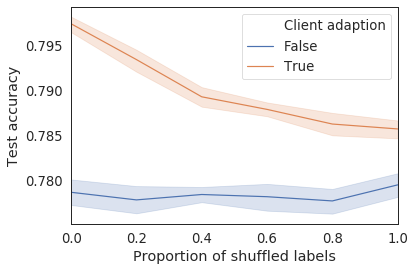

In [259]:
sns.set(context= 'paper', style = 'white', font_scale = 1.5)

sns_plot = sns.lineplot(x=all_df['Proportion of shuffled labels'], y=all_df['Test accuracy'],
                     hue=all_df['Client adaption'],)
sns_plot.set_xlim(0,1)
plt.tight_layout()
plt.show()
sns_plot.get_figure().savefig('CIFAR10.pdf', dpi=400)

# AUDIO

In [260]:
runs = api.runs("[FILL IN]")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in tqdm_notebook(runs): 

    if  hasattr(run, 'config') and run.config['experiment_group'] =="cough_detector_v3":
        summary_list.append(run.summary._json_dict)
        config = {k:v for k,v in run.config.items() if not k.startswith('_')}
        config_list.append(config) 
        name_list.append(run.name)     
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
audio_df = pd.concat([name_df, config_df,summary_df], axis=1)
# all_df = all_df[all_df.all_client_data_centrally.isnull()]
audio_df = audio_df.rename(columns={'final_test/auc': 'Test AUC', 
                                    'global_conditioning' : 'Client adaption', 
                                    'label_shuffle_percentage': 'Proportion of shuffled labels',
                                    'client_average_frechet': 'Average client Fréchet distance'})

In [271]:
start = audio_df['_timestamp'].values[0]

out = audio_df.groupby(['Client adaption', 'Proportion of shuffled labels'])
print(out['seed'].count())

non_adaption_filter = audio_df['Client adaption'] == False
magic_number = 60*60*40 # <--- increasing this reduces number of false reps
time_stamp_filter = audio_df['_timestamp'] > start - magic_number
audio_df_balanced_reps = audio_df.drop(audio_df.loc[non_adaption_filter & time_stamp_filter].index)

adaption_filter = audio_df_balanced_reps['Client adaption'] == True
magic_number = 60*60*0.3 # <--- increasing this reduces number of true reps
time_stamp_filter = audio_df_balanced_reps['_timestamp'] > start - magic_number
audio_df_balanced_reps = audio_df_balanced_reps.drop(audio_df_balanced_reps.loc[adaption_filter & time_stamp_filter].index)



out = audio_df_balanced_reps.groupby(['Client adaption', 'Proportion of shuffled labels'])
print(out['seed'].count())

Client adaption  Proportion of shuffled labels
False            0.0                              51
                 0.2                              48
                 0.4                              48
                 0.6                              48
                 0.8                              48
                 1.0                              48
True             0.0                              24
                 0.2                              24
                 0.4                              24
                 0.6                              24
                 0.8                              24
                 1.0                              21
Name: seed, dtype: int64
Client adaption  Proportion of shuffled labels
False            0.0                              21
                 0.2                              21
                 0.4                              21
                 0.6                              21
                 0.8             

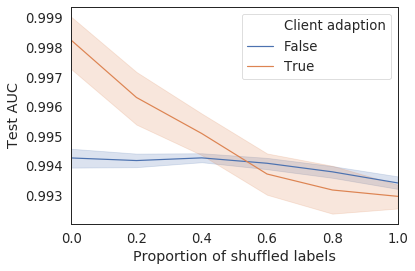

In [262]:
sns.set(context= 'paper', style = 'white', font_scale = 1.5)

sns_plot = sns.lineplot(x=audio_df_balanced_reps['Proportion of shuffled labels'], y=audio_df_balanced_reps['Test AUC'],
                     hue=audio_df_balanced_reps['Client adaption'],)

# new_title = ''
# sns_plot.legend_.set_title(new_title)

# new_labels = ['','Baseline', 'With client adaption']
# for t, l in zip(sns_plot.legend_.texts, new_labels): t.set_text(l)

sns_plot.set_xlim(0,1)
plt.tight_layout()
plt.show()
sns_plot.get_figure().savefig('AUUDIO.pdf', dpi=400)


In [263]:
out = (audio_df_balanced_reps[['Average client Fréchet distance', 'Proportion of shuffled labels']]
        .groupby(['Proportion of shuffled labels'])[['Average client Fréchet distance']]
        .mean())

print(out.transpose().to_latex(float_format="%.1f",
                               caption="...",
                               label="tab:frechet"))


\begin{table}
\centering
\caption{...}
\label{tab:frechet}
\begin{tabular}{lrrrrrr}
\toprule
Proportion of shuffled labels &    0.0 &   0.2 &   0.4 &   0.6 &  0.8 &  1.0 \\
\midrule
Average client Fréchet distance & 1784.2 & 980.7 & 555.1 & 270.6 & 90.7 & 19.6 \\
\bottomrule
\end{tabular}
\end{table}

